In [1]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import A2C
from stable_baselines.common.env_checker import check_env
from IPython.display import clear_output
import time


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



defaultdict(<class 'list'>, {0: [2, 1, 3], 1: [2, 3], 2: [3, 4], 3: [4], 5: [2, 3, 4]})


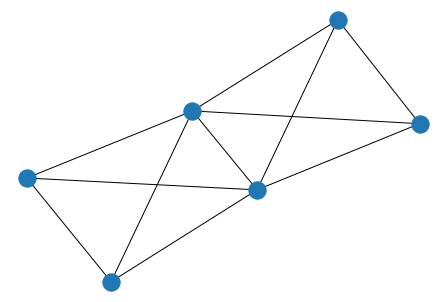

In [2]:
import gym
import w_mac
from collections import defaultdict
import matplotlib as plt
import networkx as nx

# data = [(0,2),(0,1),(1,2),(2,3),(2,4),(3,4)]
#data = [(0,1),(0,8),(0,7),(0,12),(0,2),(1,2),(1,12),(1,5),(1,6),(1,14),(1,7),(1,8),(5,6),(5,14),(6,14),(8,7),(12,2),(2,3),(2,4),(4,13),(4,9),(4,11),(4,10),(10,11),(9,13),(3,4),(9,10),(9,11),(5,15)]
d = defaultdict(list)
data = [(0,2),(0,1),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4),(5,2),(5,3),(5,4)]
# defaultdict(<type 'list'>, {})
for node, dest in data:
    d[node].append(dest)
print(d)

G = nx.Graph()
for k,v in d.items():
    for vv in v:
        G.add_edge(k,vv)
nx.draw(G)

self.collision_domain {5: [0, 1, 2, 3], 8: [2, 3, 4, 5]}
self.node_in_domains :  {0: [5], 1: [5], 2: [5, 8], 3: [5, 8], 4: [8], 5: [8]}
self.attack_nodes [5]
self.node_action_list {0: [0, 1, 2, 3], 2: [0, 1, 2, 3, 4, 5], 1: [0, 1, 2, 3], 3: [0, 1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [2, 3, 4, 5]}
sorted self.node_action_list {0: [0, 1, 2, 3], 2: [0, 1, 2, 3, 4, 5], 1: [0, 1, 2, 3], 3: [0, 1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [2, 3, 4, 5]}
action_space MultiDiscrete([4 6 4 6 4 4])
MultiDiscrete([7 7 7 7 7 7 6])
[6 5 5 1 0 1 3]
------------------ resetting environment--------------------
self.attack_nodes [5]
[4, 4, 3, 1, 2, 6, 5]


array([4, 4, 3, 1, 2, 6, 5])

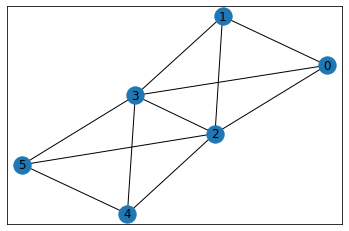

In [3]:
env = gym.make('wmac-graph-v0',graph=G)
env.reset()

In [4]:
check_env(env)

------------------ resetting environment--------------------
self.attack_nodes [5]
[3, 3, 4, 1, 0, 6, 5]
Packet lost due to passing to defect node 4 index 4 [3, 1, 6, 4, 5, 6] [1, 1, 0, 1, 1, 0]
packets delivered  0
packet_lost  25
------------------ resetting environment--------------------
self.attack_nodes [0]
[6, 4, 2, 1, 1, 3, 0]
Packet lost due to passing to defect node 3 index 3 [6, 4, 2, 0, 2, 6] [0, 1, 1, 1, 1, 0]
Packet lost due to passing to defect node 1 index 2 [6, 5, 0, 0, 2, 6] [0, 1, 1, 1, 1, 0]
Packet lost due to passing to defect node 3 index 3 [6, 5, 0, 0, 2, 6] [0, 1, 1, 1, 1, 0]
Packet lost due to passing to defect node 2 index 1 [6, 0, 0, 1, 6, 2] [0, 1, 1, 1, 0, 1]
Packet lost due to passing to defect node 1 index 2 [6, 0, 0, 1, 6, 2] [0, 1, 1, 1, 0, 1]


In [4]:
model = A2C(MlpPolicy, env, verbose=1) #,tensorboard_log="./diffrange_tensorboard/"
model.learn(total_timesteps=5000)
model.save("a2c_wmac")

to passing to defect node 1 index 2 [2, 0, 3, 6, 5, 6] [1, 1, 1, 0, 1, 0]
Packet lost due to passing to defect node 5 index 5 [1, 5, 0, 6, 6, 3] [1, 1, 1, 0, 0, 1]
Packet lost due to passing to defect node 1 index 2 [6, 5, 3, 6, 5, 3] [0, 1, 1, 0, 1, 1]
Packet lost due to passing to defect node 5 index 5 [6, 5, 3, 6, 5, 3] [0, 1, 1, 0, 1, 1]
Packet lost due to passing to defect node 5 index 5 [6, 0, 0, 6, 2, 3] [0, 1, 1, 0, 1, 1]
Packet lost due to passing to defect node 0 index 0 [3, 3, 0, 6, 5, 6] [1, 1, 1, 0, 1, 0]
Packet lost due to passing to defect node 2 index 1 [3, 3, 0, 6, 5, 6] [1, 1, 1, 0, 1, 0]
Packet lost due to passing to defect node 0 index 0 [3, 3, 0, 6, 6, 4] [1, 1, 1, 0, 0, 1]
packets delivered  0
packet_lost  25
------------------ resetting environment--------------------
self.attack_nodes [0]
[6, 4, 3, 2, 3, 3, 0]
Packet lost due to passing to defect node 2 index 1 [6, 0, 0, 0, 5, 3] [0, 1, 1, 1, 1, 1]
Packet lost due to passing to defect node 1 index 2 [6, 0, 0, 0,

In [6]:
del model # remove to demonstrate saving and loading

Loading a model without an environment, this model cannot be trained until it has a valid environment.
------------------ resetting environment--------------------
self.attack_nodes [5]
[4, 3, 0, 1, 2, 6, 5]
Packet lost due to passing to defect node 2 index 1 [3, 5, 0, 2, 6, 6] [1, 1, 1, 1, 0, 0]
count : 1
count : 2
Packet lost due to passing to defect node 3 index 3 [3, 0, 2, 5, 3, 6] [1, 1, 1, 1, 1, 0]
count : 3
count : 4
count : 5
Packet lost due to passing to defect node 4 index 4 [3, 4, 3, 1, 5, 6] [1, 1, 1, 1, 1, 0]
count : 6
count : 7
packets delivered  0
packet_lost  25
count : 8
src nodes [0, 3, 0]
next_hop edges [1, 5, 1]


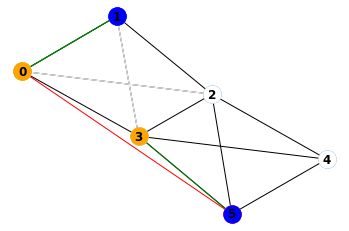

In [7]:
model = A2C.load("a2c_wmac")

obs = env.reset()
count = 0
while count < 100:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    count = count + 1
    print("count :", count)
    if done:
        clear_output(wait = True)
        time.sleep(3)
        env.render()
        break
    
    